## **Assignment 7 : Multi-Class Model Selection using ROC and PRC**

## **Introduction :**
This assignment focuses on multi-class model selection using the Landsat Satellite dataset, where various classifiers are compared through ROC and Precision–Recall curve analysis. The goal is to evaluate each model’s ability to distinguish land cover types and recommend the best-performing classifier based on its overall accuracy, AUC, and average precision across classes.

---

**Importing Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.metrics import auc as sk_auc


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = True

**Load and prepare data (UCI Landsat Satellite Dataset)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ColabData/sat.trn", header=None, sep=r"\s+", engine='python')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [ ]:
print(df.shape)   # should be (4435, 37)


(4435, 37)


- Separate the Label Class from the Dataset .

In [ ]:
# Correct slicing
X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values

print("✅ Features shape:", X.shape)
print("✅ Labels shape:", y.shape)


✅ Features shape: (4435, 36)
✅ Labels shape: (4435,)


In [ ]:
print(X[0])
print(y[0])

[ 92 115 120  94  84 102 106  79  84 102 102  83 101 126 133 103  92 112
 118  85  84 103 104  81 102 126 134 104  88 121 128 100  84 107 113  87]
3


**Now , We standardize our Data **

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**Train-test split for Traing & testing our Models :**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
print("Train / Test shapes:", X_train.shape, X_test.shape)

Train / Test shapes: (3104, 36) (1331, 36)


Eventually , we define our models Required :

In [ ]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Dummy(Prior)": DummyClassifier(strategy="prior", random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class="ovr", solver="lbfgs", random_state=RANDOM_STATE),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, kernel='rbf', random_state=RANDOM_STATE)
}

**Training all our 6 Models :**

In [ ]:
fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f"Trained: {name}")

Trained: KNN
Trained: DecisionTree
Trained: Dummy(Prior)
Trained: LogisticRegression
Trained: GaussianNB
Trained: SVC


### **Baseline Evaluation:**
- We calculated Simple Accuracy and Weighted F1- Score for each model .
- And then we sort them according to their Accuracy .


In [ ]:
# Evaluate baseline metrics: Accuracy and Weighted F1
from collections import OrderedDict
baseline_results = OrderedDict()

for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    w_f1 = f1_score(y_test, y_pred, average='weighted')
    baseline_results[name] = {"accuracy": acc, "weighted_f1": w_f1}

# Show results
pd.DataFrame(baseline_results).T.sort_values("accuracy", ascending=False)


,accuracy,weighted_f1
KNN,0.890308,0.889376
SVC,0.885049,0.880244
LogisticRegression,0.839219,0.816289
DecisionTree,0.829452,0.829460
GaussianNB,0.780616,0.789768
Dummy(Prior),0.241923,0.094252


**We observe Dummy Classifier give both poor Accuracy and weighted F1_score as it does not use any input features('X') and always predicts the majority class**


---
## **Part B: ROC Analysis for Model Selection**

**Explanation of APPROACH:**

---

**One-vs-Rest (OvR) approach is used to generate ROC curves :**

In the OvR approach:
- We split the multi-class problem into multiple binary subproblems.
- For each class Ci :
     - Treat Ci as the positive class.
     - Treat all other classes as the negative class (rest).

So if you have 6 classes, you get 6 binary classification problems.

**How ROC is Computed in OvR :**

For each class Ci :
1. The classifier gives a probability score (or decision function) Pi(x) that represents the likelihood that sample x belongs to class i.
2. **Using these scores:**

    - Compute the True Positive Rate (TPR) and False Positive Rate (FPR) across different thresholds.
    - Plot the ROC curve for that class:


### ROC Curve and Area Under Curve(AUC) for Class \(Ci\)

**True Positive Rate (TPR)** and **False Positive Rate (FPR)** are defined as:

              TPR = TP⁄(TP + FN)  

              FPR = FP⁄(FP + TN)

where:  
- **TP** = True Positives  
- **FN** = False Negatives  
- **FP** = False Positives  
- **TN** = True Negatives  

The **ROC (Receiver Operating Characteristic) curve** plots TPR against FPR across different classification thresholds.

The **Area Under the ROC Curve (AUC)** for class \(Ci\) is given by:

        AUCᵢ = ∫₀¹ TPRᵢ(FPRᵢ) d(FPRᵢ)


This represents the probability that the classifier ranks a random positive instance higher than a random negative one for class Ci
 .

 ---

 Here we use AUC Package from Sklearn library to calculate AUC for each Model .

**One-vs-Rest binarization of labels**

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

roc_results = {}

for name, model in fitted_models.items():

    # obtain per-class scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # per-class ROC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    macro_auc = auc(all_fpr, mean_tpr)

    roc_results[name] = {"fpr": all_fpr, "tpr": mean_tpr, "macro_auc": macro_auc}



**OvR ROC curves for all six models :**

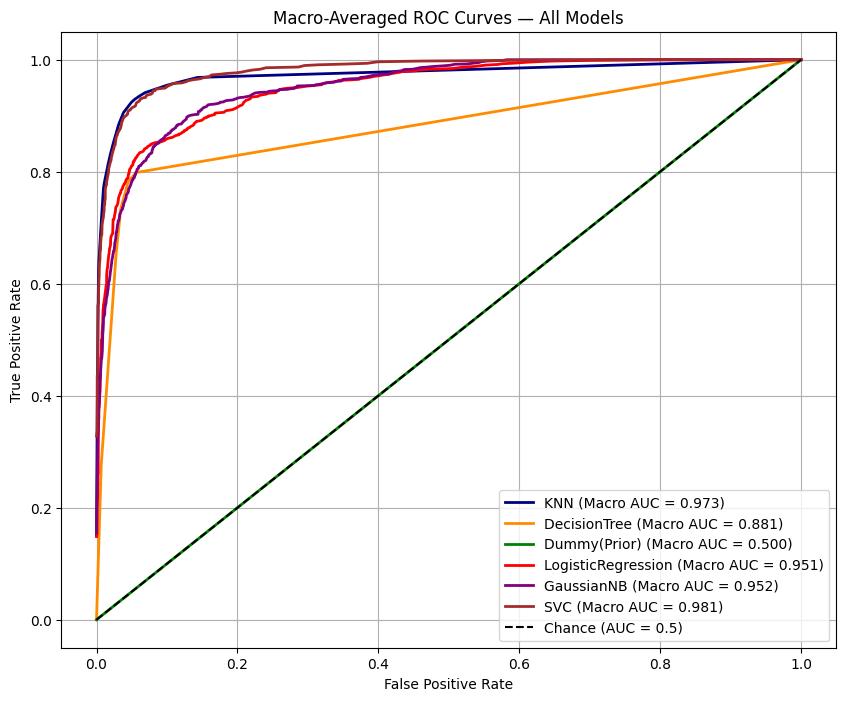

In [ ]:
plt.figure(figsize=(10, 8))
colors = cycle(["navy", "darkorange", "green", "red", "purple", "brown"])
for (name, res), c in zip(roc_results.items(), colors):
    plt.plot(res["fpr"], res["tpr"], color=c,
             label=f"{name} (Macro AUC = {res['macro_auc']:.3f})", lw=2)

plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC Curves — All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Finding the best model and model with AUC<0.5 :**

In [ ]:
macro_aucs = {name: res["macro_auc"] for name, res in roc_results.items()}
best_model = max(macro_aucs, key=macro_aucs.get)
worst_models = [m for m, v in macro_aucs.items() if v < 0.5]

print(" Best model by Macro AUC:", best_model, f"(AUC = {macro_aucs[best_model]:.3f})")
print(" No model has Macro AUC < 0.5")

 Best model by Macro AUC: SVC (AUC = 0.981)
 No model has Macro AUC < 0.5


**Support Vector Machine Classifier** has the highest Macro AUC .

No Model show Macro AUC <0.5 .

## **Why Model shows AUC < 0.5 ?**

Although **no model** in our analysis produced a Macro **AUC below 0.5**, a model with AUC < 0.5 would conceptually indicate performance worse than random guessing — meaning it consistently ranks negative samples above positive ones.

 This can **occur due to inverted decision boundaries**, **poor feature scaling**, or **inappropriate model assumptions**, such as in a Dummy or Naive Bayes classifier on complex datasets.

PART C:

### **why the Precision-Recall Curve (PRC) is a more suitablemetric than ROC when dealing with highly imbalanced classes ?**

---

The Precision–Recall Curve (PRC) is more suitable than the ROC curve for imbalanced datasets as :
- **PRC focuses on the positive (minority) class**, unlike ROC which includes true negatives.
- ROC can look overly optimistic when negatives dominate (common in imbalanced data).
- PRC directly measures precision vs recall, showing how reliable positive predictions are.
- It Highlights performance on rare or important classes, where precision matters most.
- Even with moderate imbalance, PRC gives a clearer view of real model effectiveness.

**Calculating Recall and Precision for the PRC curves for all models :**

In [ ]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

prc_results = {}

for name, model in fitted_models.items():
    # Get predicted scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    precision, recall, avg_precision = {}, {}, {}
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Macro-average: unweighted mean of per-class curves
    all_recall = np.unique(np.concatenate([recall[i] for i in range(len(classes))]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(len(classes)):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)

    macro_ap = np.mean(list(avg_precision.values()))

    prc_results[name] = {
        "recall": all_recall,
        "precision": mean_precision,
        "macro_ap": macro_ap,
        "avg_precision": avg_precision,
    }

**plotting the OvR PRC curves for all six models :**

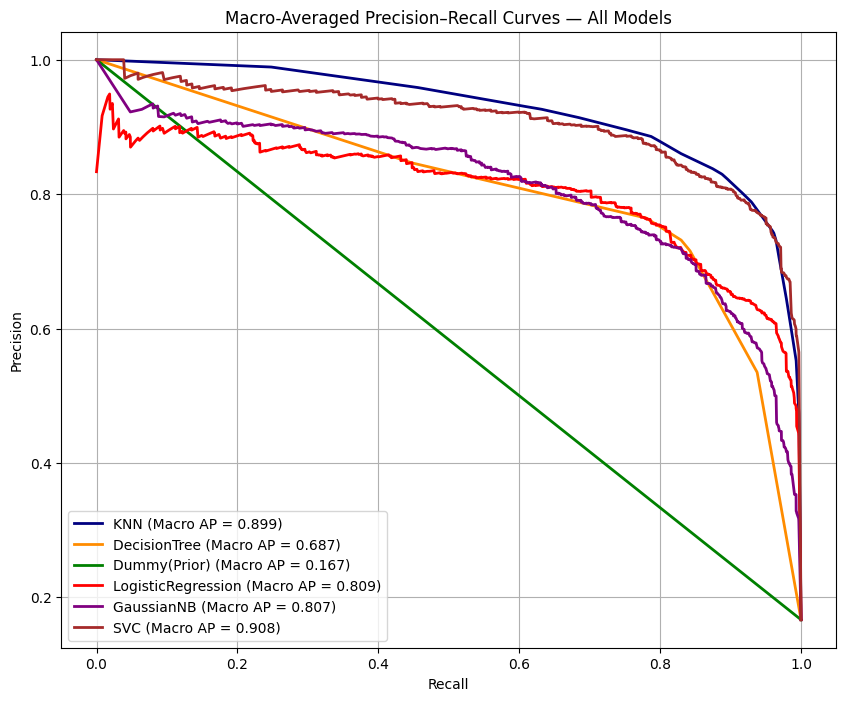

In [ ]:
plt.figure(figsize=(10, 8))
colors = cycle(["navy", "darkorange", "green", "red", "purple", "brown"])
for (name, res), c in zip(prc_results.items(), colors):
    plt.plot(res["recall"], res["precision"], color=c,
             label=f"{name} (Macro AP = {res['macro_ap']:.3f})", lw=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision–Recall Curves — All Models")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [ ]:
macro_aps = {name: res["macro_ap"] for name, res in prc_results.items()}
best_model_pr = max(macro_aps, key=macro_aps.get)
worst_model_pr = min(macro_aps, key=macro_aps.get)

print("🏆 Best model by Macro Average Precision:", best_model_pr,
      f"(AP = {macro_aps[best_model_pr]:.3f})")
print("⚠️ Worst model by Macro Average Precision:", worst_model_pr,
      f"(AP = {macro_aps[worst_model_pr]:.3f})")

🏆 Best model by Macro Average Precision: SVC (AP = 0.908)
⚠️ Worst model by Macro Average Precision: Dummy(Prior) (AP = 0.167)


**SVC model with the highest Average Precision (AP).**

**Dummy(Prior)** Model shows worst Average Precision (AP) .

---

**Analyzing the Behavior of Dummy (Prior) Model :**

- The Dummy Classifier (Prior) always predicts the majority class, regardless of the input features.
- It does not learn any relationship between features and labels.

Therefore, it provides constant or near-random predictions across all samples.

**Look at the PRC curve , I plotted to show tradeoff b/w Precision and Recall in Dummy(Prior) Model .**

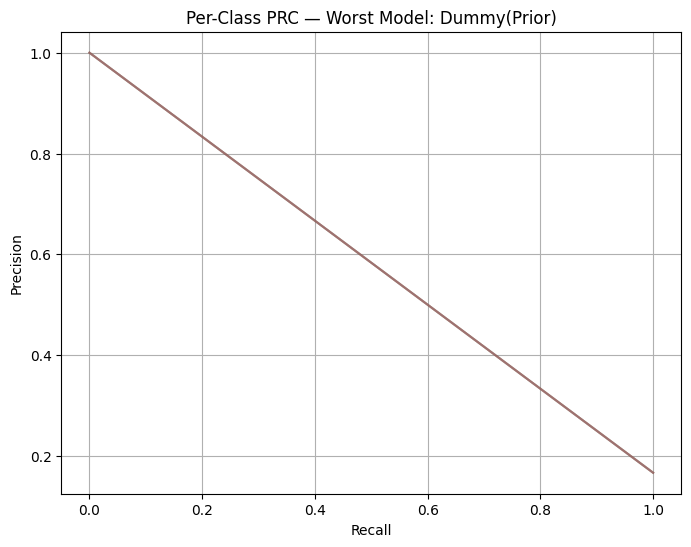

In [ ]:
res = prc_results[worst_model_pr]
plt.figure(figsize=(8, 6))
for i, c in enumerate(classes):
    plt.plot(res["recall"], res["precision"], alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Per-Class PRC — Worst Model: {worst_model_pr}")
plt.grid(True)
plt.show()

## **Why does the curve drop sharply as Recall increases for poor models?**
First look at the following:

**Precision vs Recall Trade-off**

- Precision = TP / (TP + FP) → “Of the predicted positives, how many are correct?”
- Recall = TP / (TP + FN) → “Of all actual positives, how many did we capture?”

For Poor models, when we increase Recall (that is , try to capture more true positives by lowering the decision threshold), we also start including many false positives, because the model cannot properly distinguish between classes.
As a result:
- True Positives (TP) increase slowly,
- False Positives (FP) increase rapidly,
so Precision = TP / (TP + FP) falls very quickly.

This causes the Precision–Recall Curve to drop sharply — the model’s
predictions become increasingly noisy as it tries to identify more positives.

→ **Therefore ,PRC drops sharply because precision falls steeply when recall increases for poor Models .(Dummy(Prior) Model as AP<0.5).**

---




PART D:

**Find F1 score , auc and Average precision(AP) for each model :**

In [ ]:
rows = []
for name in fitted_models.keys():
    f1  = baseline_results[name]["weighted_f1"]
    auc = roc_results[name]["macro_auc"]
    ap  = prc_results[name]["macro_ap"]
    rows.append({"Model": name, "F1": f1, "ROC_AUC": auc, "PRC_AP": ap})

metrics_df = pd.DataFrame(rows).set_index("Model").round(4)

**Ranking the model according to different metrics :**

In [ ]:
# Compute ranks (1 = best)
metrics_df["Rank_F1"]      = metrics_df["F1"].rank(ascending=False, method="min").astype(int)
metrics_df["Rank_ROC_AUC"] = metrics_df["ROC_AUC"].rank(ascending=False, method="min").astype(int)
metrics_df["Rank_PRC_AP"]  = metrics_df["PRC_AP"].rank(ascending=False, method="min").astype(int)


In [ ]:
# Combined rank (sum) and rank spread
metrics_df["Rank_Sum"] = metrics_df[["Rank_F1", "Rank_ROC_AUC", "Rank_PRC_AP"]].sum(axis=1)
metrics_df["Rank_Spread"] = metrics_df[["Rank_F1", "Rank_ROC_AUC", "Rank_PRC_AP"]].max(axis=1) - metrics_df[["Rank_F1", "Rank_ROC_AUC", "Rank_PRC_AP"]].min(axis=1)


**Display the final Result :**

In [ ]:
# Sort by combined rank for summary
metrics_sorted = metrics_df.sort_values(["Rank_Sum", "Rank_Spread"])
display(metrics_sorted[['Rank_F1','Rank_PRC_AP', 'Rank_ROC_AUC']])


,Rank_F1,Rank_PRC_AP,Rank_ROC_AUC
Model,,,
SVC,2,1,1
KNN,1,2,2
LogisticRegression,4,3,4
GaussianNB,5,4,3
DecisionTree,3,5,5
Dummy(Prior),6,6,6


In [ ]:
DISAGREE_THRESHOLD = 2
disagreeing = metrics_sorted[metrics_sorted["Rank_Spread"] >= DISAGREE_THRESHOLD]

if not disagreeing.empty:
    print(f"\n⚠️ Models with notable ranking disagreement (Rank_Spread >= {DISAGREE_THRESHOLD}):")
    display(disagreeing)
else:
    print(f"\n✅ No models have Rank_Spread >= {DISAGREE_THRESHOLD}; rankings largely agree.")




⚠️ Models with notable ranking disagreement (Rank_Spread >= 2):


,F1,ROC_AUC,PRC_AP,Rank_F1,Rank_ROC_AUC,Rank_PRC_AP,Rank_Sum,Rank_Spread
Model,,,,,,,,
GaussianNB,0.7898,0.9521,0.8075,5,3,4,12,2
DecisionTree,0.8295,0.8809,0.6871,3,5,5,13,2


In [ ]:
print("Look at the their Rank :")
for model_name in disagreeing.index:
    row = disagreeing.loc[model_name]
    print("────────────────────────────────────────────────────────")
    print(f"Model: {model_name}")
    print(f"  F1 = {row['F1']:.4f} (Rank {row['Rank_F1']})")
    print(f"  ROC_AUC = {row['ROC_AUC']:.4f} (Rank {row['Rank_ROC_AUC']})")
    print(f"  PRC_AP = {row['PRC_AP']:.4f} (Rank {row['Rank_PRC_AP']})")
    print(f"  Rank spread = {int(row['Rank_Spread'])} ")

────────────────────────────────────────────────────────
Model: GaussianNB
  F1 = 0.7898 (Rank 5.0)
  ROC_AUC = 0.9521 (Rank 3.0)
  PRC_AP = 0.8075 (Rank 4.0)
  Rank spread = 2 -> disagreement detected
────────────────────────────────────────────────────────
Model: DecisionTree
  F1 = 0.8295 (Rank 3.0)
  ROC_AUC = 0.8809 (Rank 5.0)
  PRC_AP = 0.6871 (Rank 5.0)
  Rank spread = 2 -> disagreement detected


**Trade offs :**
- The rankings are mostly consistent at the top and bottom:
SVC and KNN consistently perform best, while Dummy(Prior) is the worst across all metrics.
- However, middle-ranked models differ slightly between metrics — e.g.,
GaussianNB scores higher on PRC-AP than on ROC-AUC.

**Explanation :**
- ROC-AUC measures overall ranking ability, while PRC-AP focuses on how well the model maintains precision as recall increases.
- A model can have high ROC-AUC but lower PRC-AP if it separates classes well overall but produces many false positives when predicting positives, showing poorer calibration or class imbalance effects.

## **Final Recommendation : SVC (Support Vector Classifier)**

Based on accuracy, F1-Score, ROC-AUC, and PRC-AP analysis, the SVC (Support Vector Classifier) is the best overall model for this classification task.

It achieves the highest Macro ROC-AUC (≈ 0.981) and Macro Average Precision (≈ 0.908), showing strong discriminative power and reliable precision across thresholds.

**KNN** also performs competitively but slightly below SVC, while all other models (Logistic Regression, GaussianNB, Decision Tree, and Dummy) show weaker balance between precision and recall.

Therefore,**SVC** is recommended as the final model because it provides the best balance between precision and recall and demonstrates stable, high performance across all evaluation curves.

## **Brownie Marks Part :**

**Train & Build the RandomForest Model and finally Stored it in Fitted_Model Dictionary :**

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
fitted_models["RandomForest"] = rf

We encodes categorical **labels into numeric form using LabelEncoder**, then trains an XGBoost classifier with **multi-class log loss** as the evaluation metric.

**The trained model is stored in the fitted_models dictionary under the key "XGBoost".**

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)  # if you have test labels

xgb_model = xgb.XGBClassifier(use_label_encoder=True, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train_encoded)
fitted_models["XGBoost"] = xgb_model


**Also, build A dummy classifier with uniform random predictions for Comparison :**

In [ ]:
dummy_rand = DummyClassifier(strategy="uniform", random_state=42)
dummy_rand.fit(X_train, y_train)
fitted_models["Dummy(Random)"] = dummy_rand

Earlier ,we build **Dummy Classifier** with prior Strategy and Now we build using **Uniform Random prediction which have AUC<0.5.**

---

**Now we evaluate our Models on Test Dataset and Calculate Required Metrics : F1_score , Area Under Curve (AUC) , Average Prediction(AP) :**

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import numpy as np

# --- Get unique class labels and binarize for multiclass ROC/PRC ---
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Test these 3 Models :

# Initialize dictionaries to store curves for plotting
roc_curves_to_plot = {}
prc_curves_to_plot = {}


for name, model in list(fitted_models.items())[-3:]:


    # 1. Predict class labels

    y_pred = model.predict(X_test)


    # 2. Evaluate baseline metrics
    acc = accuracy_score(y_test, y_pred)
    wf1 = f1_score(y_test, y_pred, average="weighted")
    baseline_results[name] = {"accuracy": acc, "weighted_f1": wf1}


    # 3. Get probability scores (for ROC/PRC curves)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)


       # ---- ROC-AUC (One-vs-Rest Macro Averaging) ----

    fpr, tpr, roc_auc_values = {}, {}, {}

    # Compute ROC curve and AUC for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc_values[i] = auc(fpr[i], tpr[i])

    # Interpolate and average across all classes to compute Macro-AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)

    macro_auc = auc(all_fpr, mean_tpr)
    roc_results[name] = {"macro_auc": macro_auc}
    roc_curves_to_plot[name] = (all_fpr, mean_tpr, macro_auc) # Store for plotting


    # ---- Precision-Recall (PRC) Macro Average ----
    precision, recall, avg_precision = {}, {}, {}

    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Interpolate and average across all classes to compute Macro-AP
    all_recall = np.unique(np.concatenate([recall[i] for i in range(len(classes))]))
    mean_precision = np.zeros_like(all_recall)

    for i in range(len(classes)):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)

    macro_ap = np.mean(list(avg_precision.values()))
    prc_results[name] = {"macro_ap": macro_ap}
    prc_curves_to_plot[name] = (all_recall, mean_precision, macro_ap) # Store for plotting


    # 4. Print results for each model
    print(f"\nModel: {name}")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Weighted F1     : {wf1:.4f}")
    print(f"Macro ROC-AUC   : {macro_auc:.4f}")
    print(f"Macro Avg. Precision (AP): {macro_ap:.4f}")


Model: RandomForest
Accuracy       : 0.8971
Weighted F1     : 0.8935
Macro ROC-AUC   : 0.9853
Macro Avg. Precision (AP): 0.9344

Model: XGBoost
Accuracy       : 0.0083
Weighted F1     : 0.0093
Macro ROC-AUC   : 0.9871
Macro Avg. Precision (AP): 0.9401

Model: Dummy(Random)
Accuracy       : 0.1510
Weighted F1     : 0.1564
Macro ROC-AUC   : 0.5000
Macro Avg. Precision (AP): 0.1667


We plotted ROC and PRC curves for these Models :

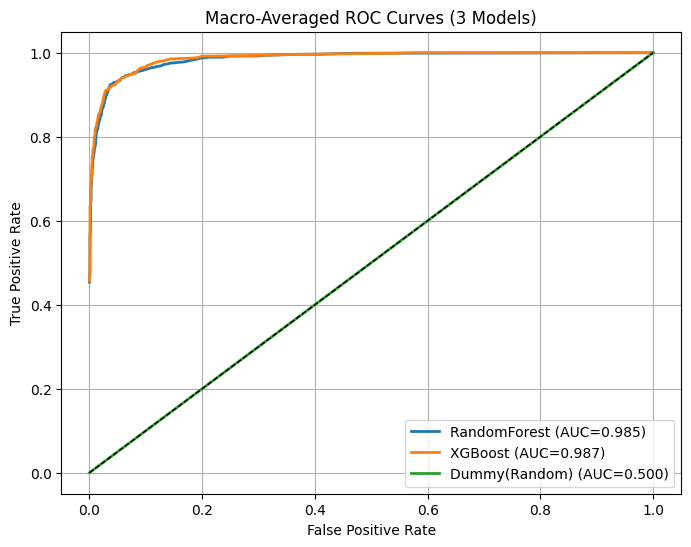

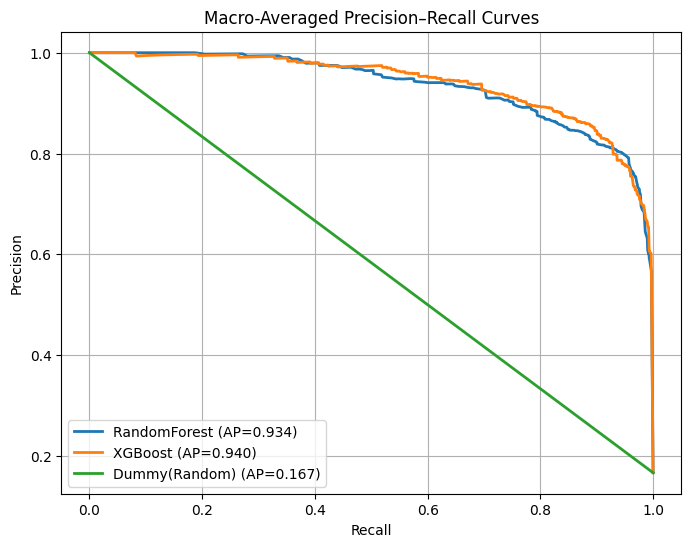

In [ ]:
# Plot all ROC curves together

plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_value) in roc_curves_to_plot.items():
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_value:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

# Plot all PRC curves together

plt.figure(figsize=(8, 6))
for name, (recall, precision, ap_value) in prc_curves_to_plot.items():
    plt.plot(recall, precision, lw=2, label=f"{name} (AP={ap_value:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

Both PRC and ROC curve of Dummy(Random) Model are straight line with -ve slope .

 while ROC Curves of Random Forest and Xgboost are non-linear, increasing & Nearly Overlaps in both cases .

 In the Case of PRC cuve , Both for Random Forest and Xgboost : non-linear, decreasing

**Now , Ranking these 3 models according to Metrics :**

In [ ]:
new_models = ["RandomForest", "XGBoost", "Dummy(Random)"]

# Combine into a summary dataframe
summary = []
for name in new_models:
    f1  = baseline_results[name]["weighted_f1"]
    auc_score = roc_results[name]["macro_auc"]
    ap  = prc_results[name]["macro_ap"]
    summary.append({"Model": name, "F1": f1, "ROC_AUC": auc_score, "PRC_AP": ap})

summary_df = pd.DataFrame(summary).set_index("Model").round(4)

# Compute ranks
summary_df["Rank_F1"] = summary_df["F1"].rank(ascending=False).astype(int)
summary_df["Rank_AUC"] = summary_df["ROC_AUC"].rank(ascending=False).astype(int)
summary_df["Rank_AP"] = summary_df["PRC_AP"].rank(ascending=False).astype(int)
summary_df["Rank_Sum"] = summary_df[["Rank_F1","Rank_AUC","Rank_AP"]].sum(axis=1)

# Sort by combined rank
summary_df = summary_df.sort_values("Rank_Sum")

# Display the summary
display(summary_df)


,F1,ROC_AUC,PRC_AP,Rank_F1,Rank_AUC,Rank_AP,Rank_Sum
Model,,,,,,,
RandomForest,0.8935,0.9853,0.9344,1,2,2,5
XGBoost,0.0093,0.9871,0.9401,3,1,1,5
Dummy(Random),0.1564,0.5000,0.1667,2,3,3,8


- **Clearly as we can see , XG Boost Model gives slightly better Area under Curve (AUC) and Average Prediction (AP) than Random Forest Model .**